In [47]:
!pip install nltk


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [48]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from itertools import product

%matplotlib inline
pd.options.display.max_colwidth=500

In [49]:
nltk.download('stopwords') 
nltk.download('wordnet')  
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


# Add dialogue context and scene features

The function creates a structured representation of each character's dialogue, incorporating context from their interactions within the same scene. This ensures that character documents capture both individual dialogue and conversational context, improving the quality of features for classification tasks.

In [51]:
# df - A data frame containing dialogue data with columns like line, character_name, episode and scene 
# max_line_count - maximum number of lines to include for each character 
def create_character_document_from_dataframe(df, max_line_count):
    
    character_docs = {}
    character_line_count = {}
    # Grouping lines by Episode and Scene to process all lines spoken within the same scene together
    grouped = df.groupby(["Episode", "Scene"])

    for (episode, scene), group in grouped:
        # Processing lines in the same scene
        for idx, row in group.iterrows():
            line = row["Line"]
            name = row["Character_name"]
            
            # Skipping empty or NaN lines
            if isinstance(line, float) and math.isnan(line) or line == "":
                continue
            
            # Initializing character documents and counts
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0
            
            # Skipping if maximum line count is reached
            if character_line_count[name] == max_line_count:
                continue
            
            # Add the target character's line
            character_docs[name] += str(line) + " _EOL_ "
            character_line_count[name] += 1

            # Add lines from other characters in the same scene for context
            for _, other_row in group.iterrows():
                if other_row["Character_name"] != name:
                    other_line = other_row["Line"]
                    if isinstance(other_line, float) and math.isnan(other_line) or other_line == "":
                        continue
                    character_docs[name] += str(other_line) + " _CONTEXT_ "

    print("lines per character", character_line_count)
    return character_docs


In [52]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  41395
OTHER Number of Words:  15706
JACK Number of Words:  34637
RONNIE Number of Words:  33239
ROXY Number of Words:  33728
TANYA Number of Words:  28930
SEAN Number of Words:  32896
MAX Number of Words:  31662
IAN Number of Words:  40423
JANE Number of Words:  42050
STACEY Number of Words:  31714
PHIL Number of Words:  46571
HEATHER Number of Words:  38866
MINTY Number of Words:  42969
CHRISTIAN Number of Words:  39436
CLARE Number of Words:  33380
total words 567602


# Improving Pre-Processing

The pre_process function processes character dialogue by prioritizing main lines and including scene context. It cleans the text, applies lemmatisation, removes unnecessary words, and generates n-grams to create a clear and structured representation.

In [53]:
# character_text: a string containing all lines spoken by a character and context lines from the same scene.
# n, defaults to bigrams
def pre_process(character_text, n=2):
# Step 1: Split context lines and target lines
    main_lines = [] # Spoken by a character
    context_lines = [] # Spoken by others in the same scene
    for line in character_text.split(" _EOL_ "):
        if "_CONTEXT_" in line: # the _CONTEXT_ marker stores context lines seperately
            context_lines.append(line.replace("_CONTEXT_", "").strip())
        else:
            main_lines.append(line.strip())
    
    # Step 2: Prioritize main lines by processing them first
    processed_main = " ".join(main_lines).lower()
    processed_context = " ".join(context_lines).lower()

    # Step 3: Pre-process both sets, punctuation is removed using regular expressions  
    processed_main = re.sub(r'[^\w\s]', '', processed_main)  # Remove punctuation
    processed_context = re.sub(r'[^\w\s]', '', processed_context)
    # The text is then tokenised
    main_tokens = processed_main.split()
    context_tokens = processed_context.split()

    # Step 4: Adding stopword removal, lemmatisation, and n-grams
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    main_tokens = [lemmatizer.lemmatize(word) for word in main_tokens if word not in stop_words]
    context_tokens = [lemmatizer.lemmatize(word) for word in context_tokens if word not in stop_words]

    # Generate n-grams for both
    main_ngrams = []
    context_ngrams = []
    for i in range(1, n + 1):
        main_ngrams.extend(["_".join(ngram) for ngram in ngrams(main_tokens, i)])
        context_ngrams.extend(["_".join(ngram) for ngram in ngrams(context_tokens, i)])

    # Combine tokens with main lines given higher priority
    return main_ngrams + context_ngrams[: len(context_ngrams) // 2]  # Downweight context

In [54]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Improving Linguistic Feature Extraction

The to_feature_vector_dictionary function creates a feature dictionary for a character's dialogue. It counts the frequency of tokens and applies a weight to context tokens to reduce their impact compared to main lines. Optionally, it adds a sentiment score as an additional feature, resulting in a dictionary representing the character's dialogue with meaningful weights and optional sentiment information.

In [55]:
def to_feature_vector_dictionary(character_doc, sentiment_score=None, context_weight=0.5):
# character_doc - a list of tokens representing character-processed dialogue
# sentiment_score - a numerical value representing the sentiment of a character's dialogue.
# Context_weight - a weighting factor to reduce the influence of context tokens compared to main tokens
    feature_dict = Counter(character_doc)
# The Counter function counts the frequency of each token in the character doc.
# Result is stored in feature_dict
    
# Apply weight to context tokens - if a token contains a _CONTEXT_ marker, its frequency is multiplied by the context weight
    for token in feature_dict:
        if "_CONTEXT_" in token:
            feature_dict[token] *= context_weight

# Add sentiment score - if a sentiment score is provided, it is added to the feature_dict as a new key-value pair.
# Key = Sentiment, Value = provided score    
    if sentiment_score is not None:
        feature_dict["sentiment"] = sentiment_score

    return feature_dict



The create_document_matrix_from_corpus function turns character feature dictionaries into a numerical matrix. It first vectorizes the features into a sparse format, applies TF-IDF to highlight important terms, and uses SVD to reduce dimensions, keeping only the most useful patterns. This makes the data easier to use for similarity evaluation and classification.

In [56]:
# Initialize global vectorizers and transformers
corpusVectorizer = DictVectorizer()   # Converts feature dictionaries to sparse feature matrices
tfidf_transformer = TfidfTransformer()  # Transforms sparse matrix into TF-IDF weighted matrix
svd = TruncatedSVD(n_components=100)  # Reduces dimensionality of the matrix

def create_document_matrix_from_corpus(corpus, fitting=False):

    global corpusVectorizer, tfidf_transformer, svd

# Extract feature dictionaries
    feature_dicts = [to_feature_vector_dictionary(doc, []) for _, doc in corpus]

# Step 1: Vectorize - convert dictionaries to sparse feature matrices
    if fitting:
        corpusVectorizer.fit(feature_dicts)  # Fit on training data
    sparse_matrix = corpusVectorizer.transform(feature_dicts)  # Transform the data

    # Step 2: Apply TF-IDF transformation, weighting features by level of importance
    if fitting:
        tfidf_transformer.fit(sparse_matrix)  # Fit on training data
    tfidf_matrix = tfidf_transformer.transform(sparse_matrix)  # Transform the data

    # Step 3: Dimensionality reduction - reduce feature dimensions using SVD
    if fitting:
        svd.fit(tfidf_matrix)  # Fit on training data
    reduced_matrix = svd.transform(tfidf_matrix)  # Transform the data

    # Convert dense matrix to sparse for compatibility with compute_IR_evaluation_scores
    reduced_sparse_matrix = csr_matrix(reduced_matrix)

    return reduced_sparse_matrix


In [57]:
# get the validation data- only 50 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  16 

OTHER Num of Words:  2931
HEATHER Num of Words:  3898
TANYA Num of Words:  4283
JACK Num of Words:  12104
RONNIE Num of Words:  5888
JANE Num of Words:  6864
STACEY Num of Words:  6050
SEAN Num of Words:  4208
PHIL Num of Words:  3858
SHIRLEY Num of Words:  4953
ROXY Num of Words:  3208
IAN Num of Words:  6165
MINTY Num of Words:  6418
CHRISTIAN Num of Words:  4157
CLARE Num of Words:  2182
MAX Num of Words:  4320
total words 81487


In [58]:
# Step 1: Fit on the training data
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# Step 2: Transform the validation data
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

# Step 3: Print the shapes of the matrices to confirm they align
print(f"Training Feature Matrix Shape: {training_feature_matrix.shape}")
print(f"Validation Feature Matrix Shape: {val_feature_matrix.shape}")


Training Feature Matrix Shape: (16, 16)
Validation Feature Matrix Shape: (16, 16)


In [59]:
training_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (16, 16)>

In [60]:
val_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (16, 16)>

In [61]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [62]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

# Parameter Search

The parameter search tests different combinations of settings like n-grams, context weight, TF-IDF, and SVD components. It evaluates each combination using mean rank and accuracy on validation data to find the best setup for the model. The goal is to optimize performance with a systematic approach.

In [63]:
# Defining parameter grid for grid search
parameter_grid = {
    'n': [1, 2, 3],
    'context_weight': [0.3, 0.5, 0.7],
    'tfidf_use_idf': [True, False],
    'svd_components': [50, 100, 150],
}

In [64]:
# train_character_docs, val_character_docs: Dictionaries of training and validation character documents.
# train_labels, val_labels: Labels corresponding to the training and validation documents
def perform_grid_search(train_character_docs, val_character_docs, train_labels, val_labels):
    global tfidf_transformer, svd
    results, best_params = [], {}  # Initialize to store results and best parameters
    best_mean_rank = float('inf')  # Track the lowest mean rank observed
    # results - A list to store the results for each parameter combination 
    # best_params - a dictionary to store the best parameter combination
    # best_mean_rank - a variable to track the lowest mean rank observed
    
    # Iterate over all combinations of parameters from the parameter grid
    for n, context_weight, tfidf_use_idf, svd_components in product(
        parameter_grid['n'], parameter_grid['context_weight'], 
        parameter_grid['tfidf_use_idf'], parameter_grid['svd_components']
    ):
        # Initializing TF-IDF transformer and SVD transformer with current parameters
        tfidf_transformer = TfidfTransformer(use_idf=tfidf_use_idf)  # Use or skip IDF weighting
        svd = TruncatedSVD(n_components=svd_components)  # Set the number of dimensions for SVD

        # Pre-processing training and validation corpora with the current n-gram parameter
        train_corpus = [(name, pre_process(doc, n)) for name, doc in sorted(train_character_docs.items())]
        val_corpus = [(name, pre_process(doc, n)) for name, doc in sorted(val_character_docs.items())]

        # Converting the pre-processed data into feature matrices using the current context weight
        train_feature_matrix = create_document_matrix_from_corpus(
            [(name, to_feature_vector_dictionary(doc, context_weight=context_weight)) for name, doc in train_corpus],
            fitting=True  # Fit transformers on training data
        )
        val_feature_matrix = create_document_matrix_from_corpus(
            [(name, to_feature_vector_dictionary(doc, context_weight=context_weight)) for name, doc in val_corpus],
            fitting=False  # Transform validation data without fitting
        )

        # Evaluating the current parameter combination using similarity metrics
        mean_rank, _, acc, _ = compute_IR_evaluation_scores(
            train_feature_matrix, val_feature_matrix, train_labels, val_labels
        )

        # Saving the results for this parameter combination
        results.append((n, context_weight, tfidf_use_idf, svd_components, mean_rank, acc))

        # Updating the best parameters if the current combination has a lower mean rank
        if mean_rank < best_mean_rank:
            best_mean_rank = mean_rank
            best_params = {
                'n': n,
                'context_weight': context_weight,
                'tfidf_use_idf': tfidf_use_idf,
                'svd_components': svd_components
            }

    # Sort results by mean rank and print the top 3 combinations
    sorted_results = sorted(results, key=lambda x: x[4])  # Sort by mean rank (index 4)
    print("\nTop 3 Parameter Combinations:")
    for result in sorted_results[:3]:
        print(f"n: {result[0]}, context_weight: {result[1]}, tfidf_use_idf: {result[2]}, svd_components: {result[3]} -> Mean Rank: {result[4]}, Accuracy: {result[5]}")

    # Return the best parameters found during the grid search
    return best_params

# Perform the grid search
best_params = perform_grid_search(train_character_docs, val_character_docs, train_labels, val_labels)
print(f"\nBest parameters found: {best_params}")


mean rank 3.25
mean cosine similarity 0.8141939919495677
8 correct out of 16 / accuracy: 0.5
mean rank 3.25
mean cosine similarity 0.8141939919495678
8 correct out of 16 / accuracy: 0.5
mean rank 3.25
mean cosine similarity 0.8141939919495677
8 correct out of 16 / accuracy: 0.5
mean rank 4.0625
mean cosine similarity 0.8715692778025504
6 correct out of 16 / accuracy: 0.375
mean rank 4.0625
mean cosine similarity 0.8715692778025504
6 correct out of 16 / accuracy: 0.375
mean rank 4.0625
mean cosine similarity 0.8715692778025506
6 correct out of 16 / accuracy: 0.375
mean rank 3.25
mean cosine similarity 0.8141939919495679
8 correct out of 16 / accuracy: 0.5
mean rank 3.25
mean cosine similarity 0.8141939919495678
8 correct out of 16 / accuracy: 0.5
mean rank 3.25
mean cosine similarity 0.8141939919495678
8 correct out of 16 / accuracy: 0.5
mean rank 4.0625
mean cosine similarity 0.8715692778025506
6 correct out of 16 / accuracy: 0.375
mean rank 4.0625
mean cosine similarity 0.871569277802

In [65]:
# Best parameters from Q4
best_n = 2  # Use bigrams for feature extraction
best_context_weight = 0.3  # Weight context lines with 30% importance compared to main lines
best_tfidf_use_idf = False  # Do not use IDF weighting in TF-IDF transformation
best_svd_components = 50  # Reduce dimensionality to 50 components with SVD

# Setting up TF-IDF transformer and SVD with the best parameters
tfidf_transformer = TfidfTransformer(use_idf=best_tfidf_use_idf)  # Initialize TF-IDF transformer with no IDF
svd = TruncatedSVD(n_components=best_svd_components)  # Initialize SVD with 50 components for dimensionality reduction

# Pre-processing training data with the best n-gram size (bigrams)
training_corpus = [
    (name, pre_process(doc, n=best_n)) for name, doc in sorted(train_character_docs.items())
]  

# Pre-processing validation data with the same n-gram size (bigrams)
val_corpus = [
    (name, pre_process(doc, n=best_n)) for name, doc in sorted(val_character_docs.items())
]  

# Generating feature matrices for training data
# Use the best context weight to prioritize main lines and down weight context lines
training_feature_matrix = create_document_matrix_from_corpus(
    [(name, to_feature_vector_dictionary(doc, context_weight=best_context_weight)) for name, doc in training_corpus],
    fitting=True  
)

# Generating feature matrices for validation data
val_feature_matrix = create_document_matrix_from_corpus(
    [(name, to_feature_vector_dictionary(doc, context_weight=best_context_weight)) for name, doc in val_corpus],
    fitting=False  
)


In [66]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [67]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.5625
mean cosine similarity 0.9297243393140403
8 correct out of 16 / accuracy: 0.5


# Heatmap

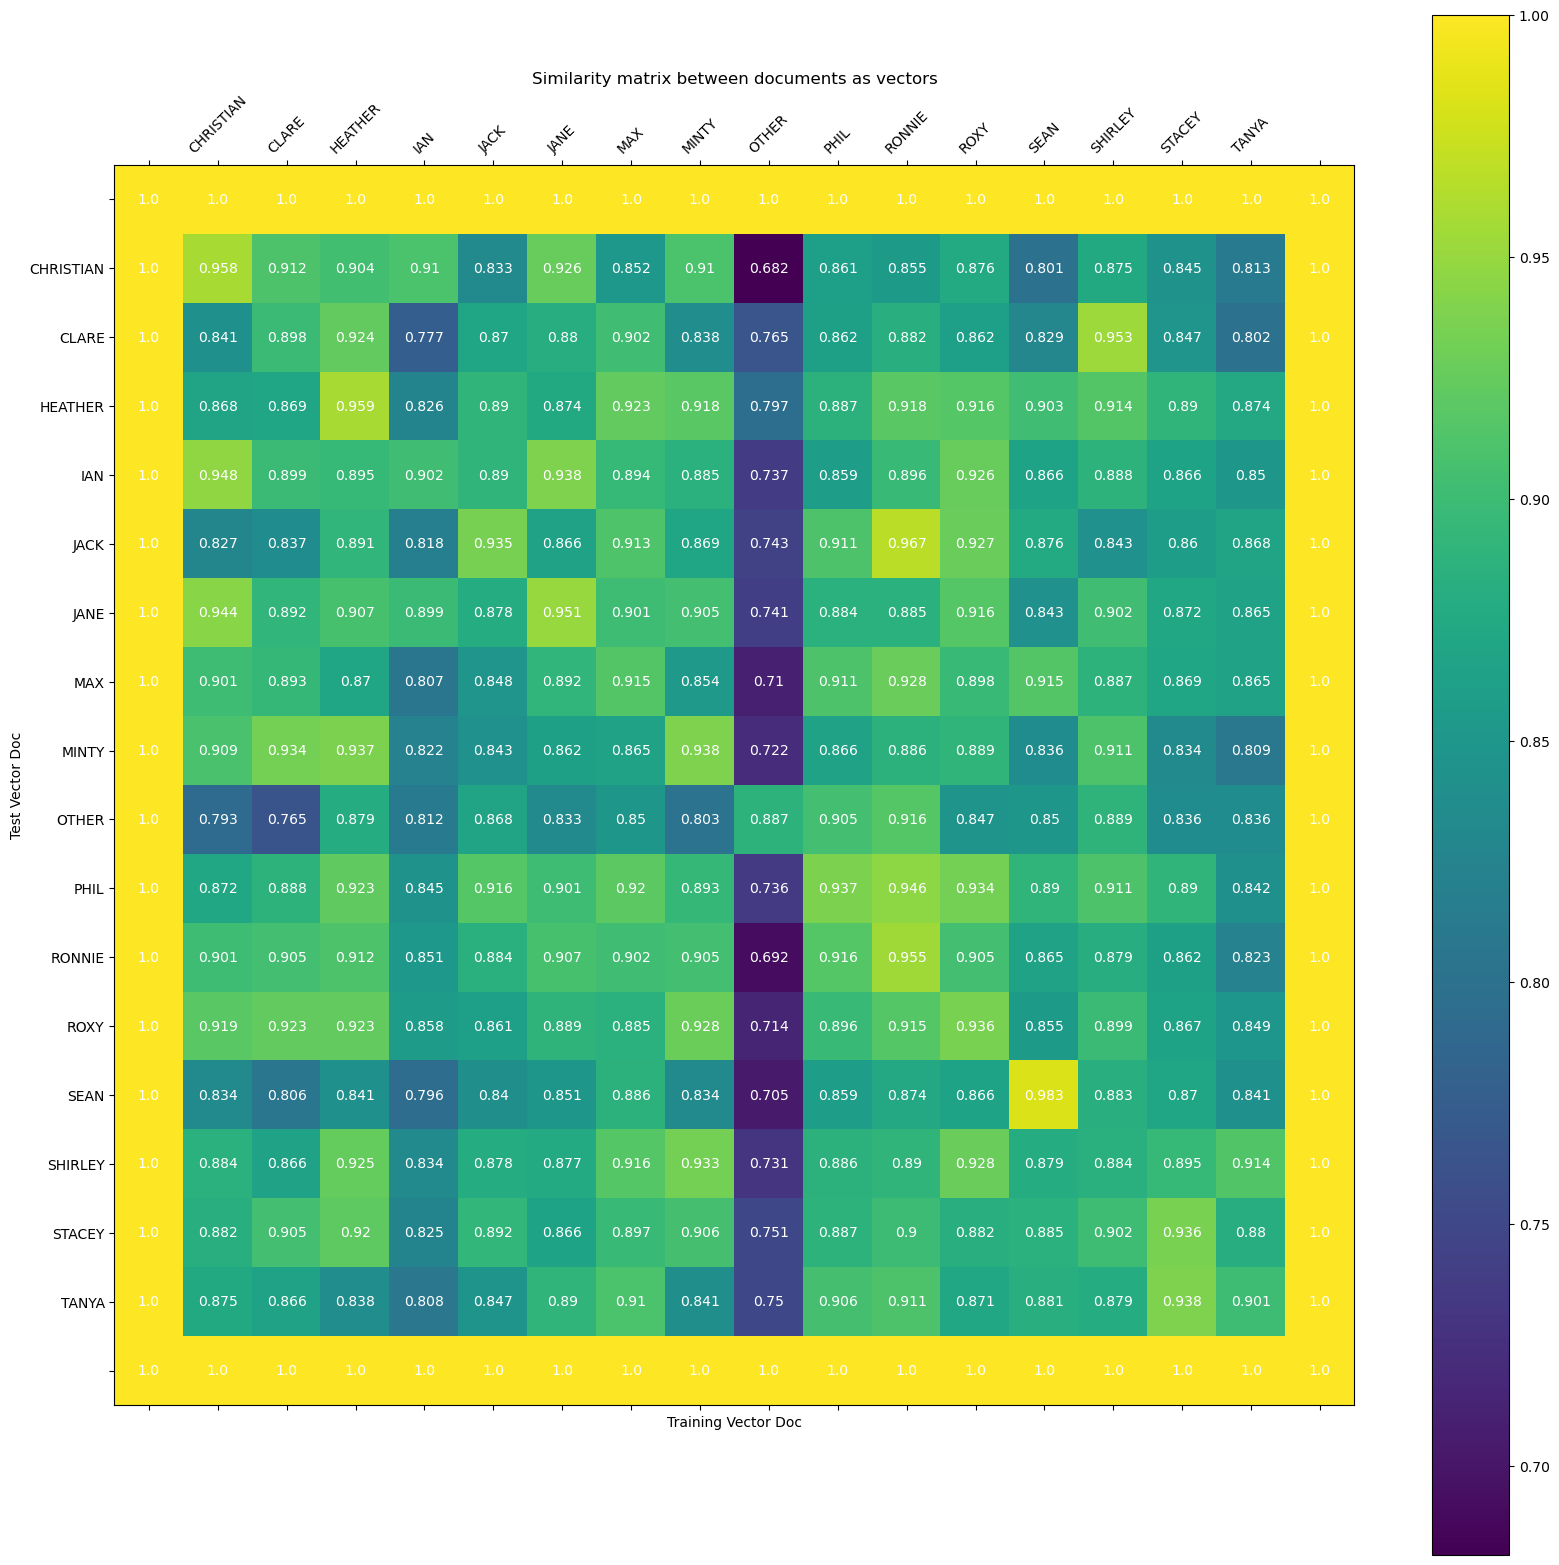

In [68]:
plot_heat_map_similarity(df)

In [69]:
# redone on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# getting the test data using 50 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=50)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# creating list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Transforming the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  41395
OTHER Number of Words:  15706
JACK Number of Words:  34637
RONNIE Number of Words:  33239
ROXY Number of Words:  33728
TANYA Number of Words:  28930
SEAN Number of Words:  32896
MAX Number of Words:  31662
IAN Number of Words:  40423
JANE Number of Words:  42050
STACEY Number of Words:  31714
PHIL Number of Words:  46571
HEATHER Number of Words:  38866
MINTY Number of Words:  42969
CHRISTIAN Number of Words:  39436
CLARE Number of Words:  33380
total words 567602
lines per character {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}
N